In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import stft, resample

# Default parameters
FS = 128            # Sampling frequency (Hz)
NPERSEG = 256       # STFT window length
NOVERLAP = 128      # Overlap between segments
FREQ_MAX = 45       # Upper frequency limit (Hz)
TIME_BINS = 32      # Time bins for spectrogram resizing
FREQ_BINS = 36      # Frequency bins for spectrogram resizing

# Path to DREAMER .mat file (update this)
DREAMER_PATH = r"C:\Users\akash\Downloads\DREAMER.mat"  # <-- change this to your actual .mat path

def load_dreamer_and_build_spectrograms(mat_path, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP,
                                        freq_max=FREQ_MAX, time_bins=TIME_BINS, freq_bins=FREQ_BINS):
    """Universal DREAMER loader — works for MATLAB structs or dicts"""
    print(f"📂 Loading DREAMER dataset from: {mat_path}")
    mat = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)

    # Handle struct or dict
    dreamer = mat.get('DREAMER', None)
    if dreamer is None:
        raise ValueError("❌ 'DREAMER' key not found in .mat file!")

    if hasattr(dreamer, 'Data'):
        data = dreamer.Data
    elif isinstance(dreamer, dict) and 'Data' in dreamer:
        data = dreamer['Data']
    else:
        raise ValueError("❌ Unknown DREAMER structure type")

    channels = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4']
    X_list, y_val, y_aro, meta = [], [], [], []

    # Helper for flattening score arrays
    def flatten_scores(s):
        if isinstance(s, (list, tuple)):
            return np.array([float(np.ravel(x)[0]) for x in s], dtype=float)
        elif isinstance(s, np.ndarray) and s.dtype == 'O':  # object (MATLAB cell)
            return np.array([float(np.ravel(x)[0]) for x in s], dtype=float)
        else:
            return np.ravel(s).astype(float)

    # Loop subjects
    for subj_idx in range(len(data)):
        subj = data[subj_idx]

        eeg = subj.EEG if hasattr(subj, 'EEG') else subj['EEG']
        baseline = eeg.baseline if hasattr(eeg, 'baseline') else eeg['baseline']
        stimuli = eeg.stimuli if hasattr(eeg, 'stimuli') else eeg['stimuli']

        sv = subj.ScoreValence if hasattr(subj, 'ScoreValence') else subj['ScoreValence']
        sa = subj.ScoreArousal if hasattr(subj, 'ScoreArousal') else subj['ScoreArousal']

        scores_val = flatten_scores(sv)
        scores_aro = flatten_scores(sa)

        n_trials = min(18, len(scores_val), len(scores_aro))
        print(f"👤 Subject {subj_idx+1:02d}: {n_trials} trials")

        # Build spectrograms per trial
        for t in range(n_trials):
            base = np.array(baseline[t])
            stim = np.array(stimuli[t])
            if base.ndim < 2 or stim.ndim < 2:
                continue

            ch_imgs = []
            for ch in range(stim.shape[1]):
                sig_b, sig_s = base[:, ch], stim[:, ch]

                # Compute STFT for baseline and stimulus
                f_b, t_b, Zb = stft(sig_b, fs=fs, nperseg=nperseg, noverlap=noverlap, boundary=None)
                f_s, t_s, Zs = stft(sig_s, fs=fs, nperseg=nperseg, noverlap=noverlap, boundary=None)
                Pb, Ps = np.abs(Zb)**2, np.abs(Zs)**2

                freq_mask = (f_s <= freq_max)
                Ps, Pb = Ps[freq_mask, :], Pb[freq_mask, :]

                # ✅ Fix shape mismatch in time dimension
                min_T = min(Ps.shape[1], Pb.shape[1])
                if Ps.shape[1] != min_T:
                    Ps = Ps[:, :min_T]
                if Pb.shape[1] != min_T:
                    Pb = Pb[:, :min_T]

                # Compute log ratio spectrogram
                ratio = np.log((Ps + 1e-12) / (Pb + 1e-12))

                # Resize to fixed grid
                if ratio.shape[1] != time_bins:
                    ratio = resample(ratio, time_bins, axis=1)
                if ratio.shape[0] != freq_bins:
                    ratio = resample(ratio, freq_bins, axis=0)
                ch_imgs.append(ratio)

            img = np.stack(ch_imgs, axis=0).astype(np.float32)
            X_list.append(img)
            y_val.append(scores_val[t])
            y_aro.append(scores_aro[t])
            meta.append((subj_idx, t))

    # Convert to arrays
    X = np.array(X_list)
    y_val = np.array(y_val).astype(float)
    y_aro = np.array(y_aro).astype(float)
    groups = np.array([m[0] for m in meta], dtype=int)

    print(f"\n✅ Built spectrogram dataset: {X.shape}")
    print(f"   • Valence labels: {y_val.shape}")
    print(f"   • Arousal labels: {y_aro.shape}")
    print(f"   • Subjects: {len(np.unique(groups))}\n")
    return X, y_val, y_aro, groups, channels


# =============================
# Run this cell to test loading
# =============================
if __name__ == "__main__":
    X, y_val, y_aro, groups, channels = load_dreamer_and_build_spectrograms(
        DREAMER_PATH, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP,
        freq_max=FREQ_MAX, time_bins=TIME_BINS, freq_bins=FREQ_BINS
    )

    print("✅ Dataset summary:")
    print(f"EEG spectrograms: {X.shape}")
    print(f"Valence labels: {y_val[:5]}")
    print(f"Arousal labels: {y_aro[:5]}")
    print(f"Unique subjects: {np.unique(groups)}")

📂 Loading DREAMER dataset from: C:\Users\akash\Downloads\DREAMER.mat
👤 Subject 01: 18 trials
👤 Subject 02: 18 trials
👤 Subject 03: 18 trials
👤 Subject 04: 18 trials
👤 Subject 05: 18 trials
👤 Subject 06: 18 trials
👤 Subject 07: 18 trials
👤 Subject 08: 18 trials
👤 Subject 09: 18 trials
👤 Subject 10: 18 trials
👤 Subject 11: 18 trials
👤 Subject 12: 18 trials
👤 Subject 13: 18 trials
👤 Subject 14: 18 trials
👤 Subject 15: 18 trials
👤 Subject 16: 18 trials
👤 Subject 17: 18 trials
👤 Subject 18: 18 trials
👤 Subject 19: 18 trials
👤 Subject 20: 18 trials
👤 Subject 21: 18 trials
👤 Subject 22: 18 trials
👤 Subject 23: 18 trials

✅ Built spectrogram dataset: (414, 14, 36, 32)
   • Valence labels: (414,)
   • Arousal labels: (414,)
   • Subjects: 23

✅ Dataset summary:
EEG spectrograms: (414, 14, 36, 32)
Valence labels: [4. 3. 5. 4. 4.]
Arousal labels: [3. 3. 4. 3. 4.]
Unique subjects: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]



==== SVM ====
Acc=0.6429, Prec=0.6429, Rec=1.0000, F1=0.7826, AUC=0.6716, Kappa=0.0000


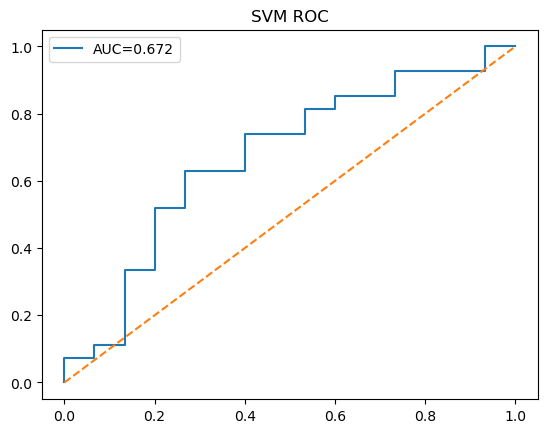

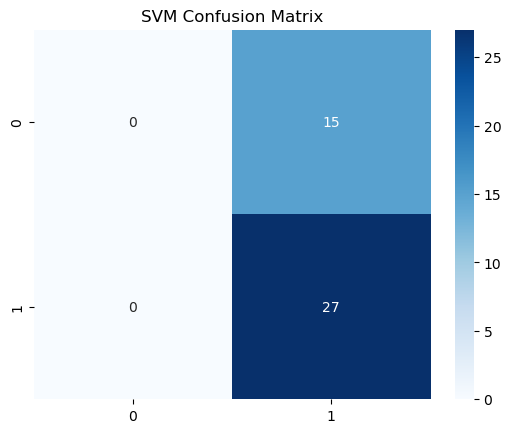


==== MLP ====
Acc=0.6429, Prec=0.6875, Rec=0.8148, F1=0.7458, AUC=0.5864, Kappa=0.1600


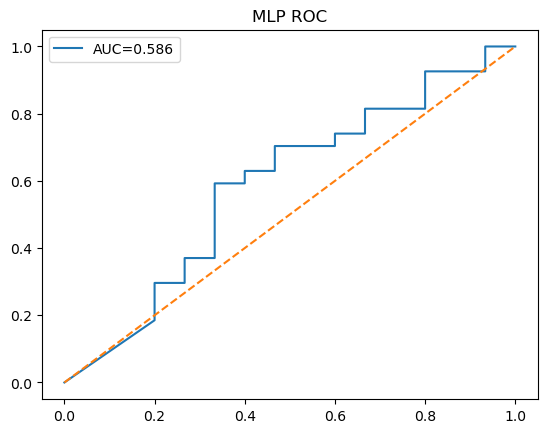

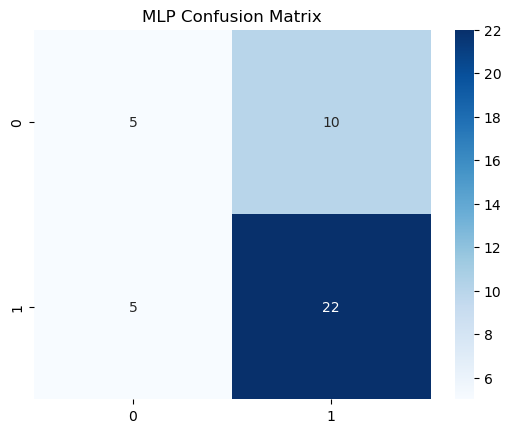


==== Cascade Forest ====
Acc=0.6429, Prec=0.6765, Rec=0.8519, F1=0.7541, AUC=0.5988, Kappa=0.1322


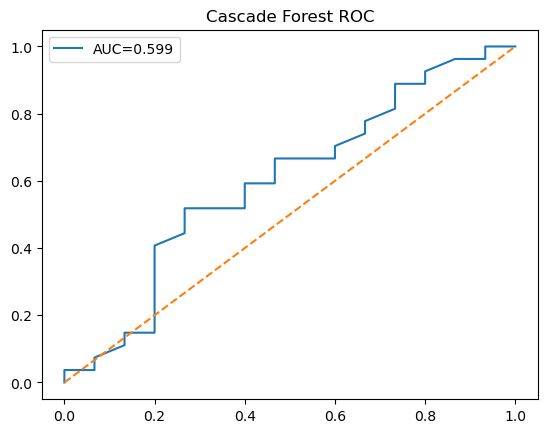

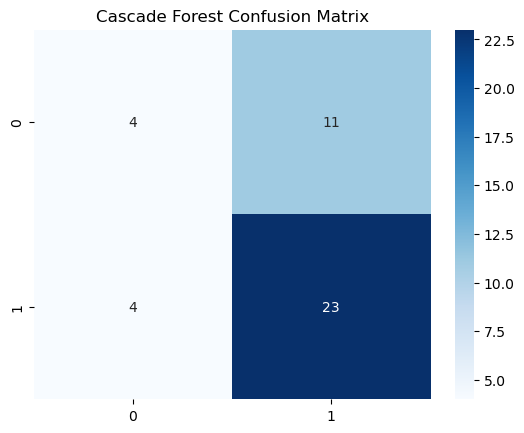


==== CNN ====
Acc=0.6905, Prec=0.6842, Rec=0.9630, F1=0.8000, AUC=0.5975, Kappa=0.1947


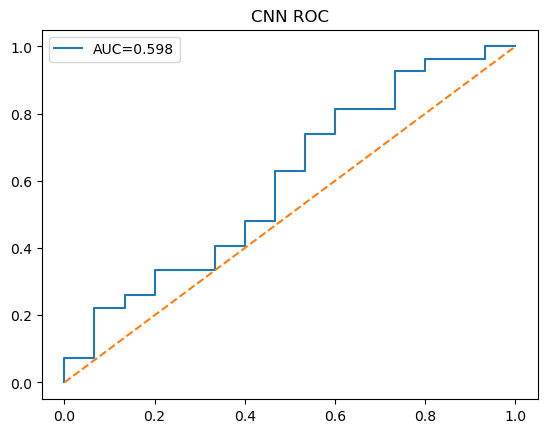

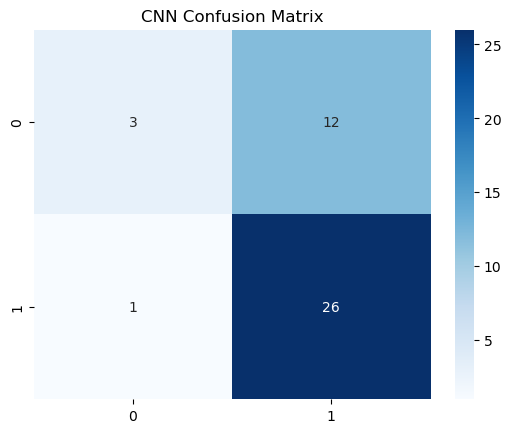


==== CNN-BiLSTM ====
Acc=0.6429, Prec=0.7143, Rec=0.7407, F1=0.7273, AUC=0.6691, Kappa=0.2105


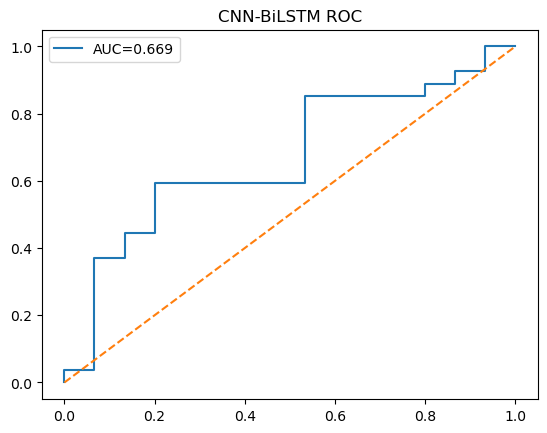

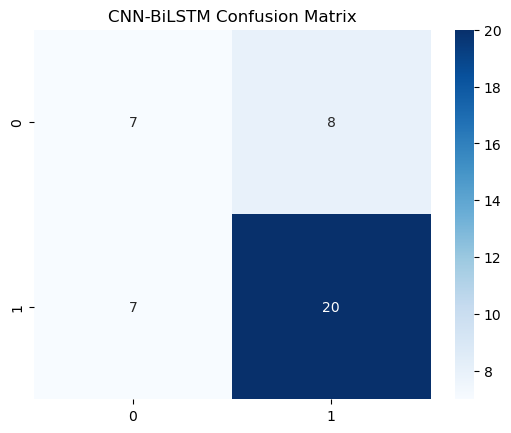


==== CNN-RNN ====
Acc=0.6190, Prec=0.6667, Rec=0.8148, F1=0.7333, AUC=0.6148, Kappa=0.0894


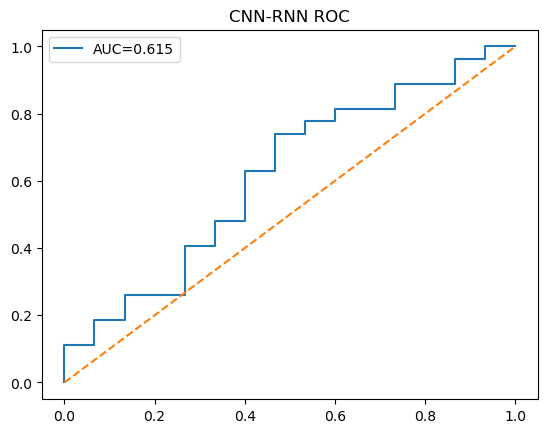

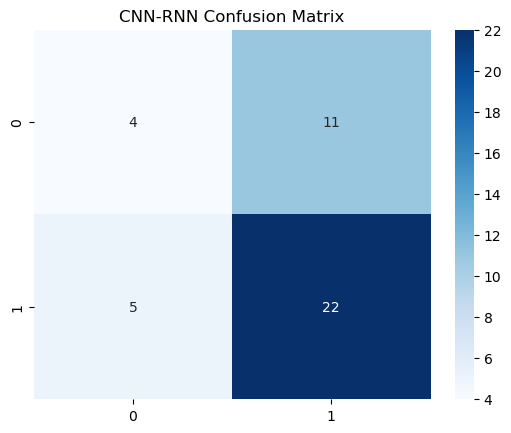


==== CapsNet ====
Acc=0.5952, Prec=0.6667, Rec=0.7407, F1=0.7018, AUC=0.6000, Kappa=0.0775


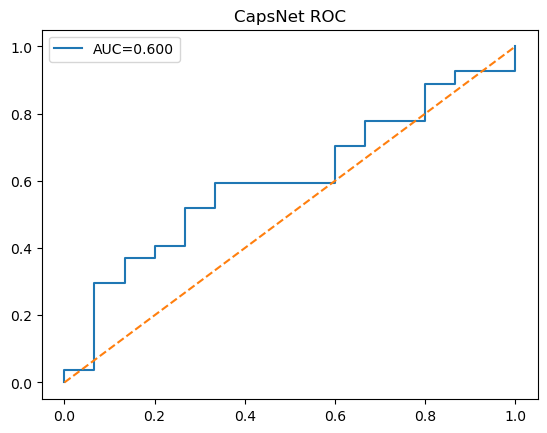

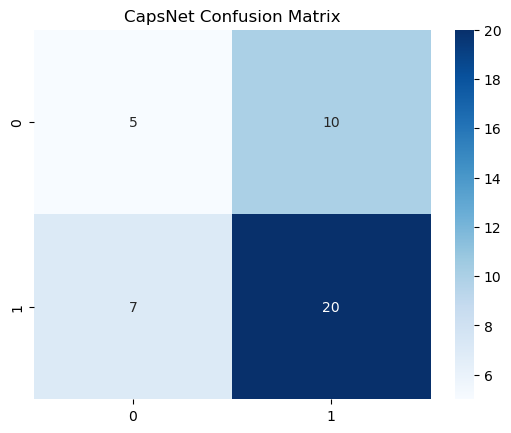

In [9]:
# ============================================================
# MULTI-MODEL EEG EMOTION RECOGNITION ON DREAMER
# Models: SVM, CNN, CNN-BiLSTM, CNN-RNN, MLP, CapsNet, Cascade Forest
# FULL METRICS + GRAPHS (TRAIN / VAL / TEST)
# ============================================================

import random, copy
import numpy as np
import scipy.io as sio
from scipy.signal import stft, resample

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve, cohen_kappa_score
)

import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- CONFIG ----------------
DREAMER_PATH = r"C:\Users\akash\Downloads\DREAMER.mat"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
EPOCHS = 40
LR = 1e-3
EARLY_STOP = 10

FS = 128
NPERSEG = 256
NOVERLAP = 128
FREQ_MAX = 45
FREQ_BINS = 36
TIME_BINS = 32

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ============================================================
# DATA LOADING
# ============================================================
def load_dreamer_spectrograms(mat_path):
    mat = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    data = mat["DREAMER"].Data

    X, y_val, y_aro = [], [], []

    for subj in np.atleast_1d(data):
        stimuli = subj.EEG.stimuli
        valence = subj.ScoreValence
        arousal = subj.ScoreArousal

        for t in range(len(stimuli)):
            sig = np.asarray(stimuli[t], float)
            ch_imgs = []

            for ch in range(sig.shape[1]):
                f, _, Z = stft(sig[:, ch], FS, nperseg=NPERSEG, noverlap=NOVERLAP)
                P = np.log(np.abs(Z[f <= FREQ_MAX])**2 + 1e-12)
                P = resample(resample(P, FREQ_BINS, axis=0), TIME_BINS, axis=1)
                ch_imgs.append(P)

            X.append(np.stack(ch_imgs))
            y_val.append(valence[t])
            y_aro.append(arousal[t])

    return np.array(X, np.float32), np.array(y_val), np.array(y_aro)

# ============================================================
# COMMON SPLIT + METRICS
# ============================================================
def split_and_binarize(X, y):
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.2, random_state=SEED)
    X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=SEED)

    thr = np.median(y_tr)
    return (
        X_tr, X_val, X_te,
        (y_tr >= thr).astype(int),
        (y_val >= thr).astype(int),
        (y_te >= thr).astype(int)
    )

def plot_metrics(y_true, y_prob, title):
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    auc = roc_auc_score(y_true, y_prob)
    kappa = cohen_kappa_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n==== {title} ====")
    print(f"Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, AUC={auc:.4f}, Kappa={kappa:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.title(title + " ROC")
    plt.legend()
    plt.show()

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title + " Confusion Matrix")
    plt.show()

# ============================================================
# DEEP MODELS
# ============================================================
class CNN(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        return self.fc(self.net(x).flatten(1)).squeeze(1)

class CNN_BiLSTM(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_ch, 64, 3, padding=1), nn.ReLU()
        )
        self.lstm = nn.LSTM(64*(FREQ_BINS), 64, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0,3,1,2).reshape(x.size(0), x.size(3), -1)
        x,_ = self.lstm(x)
        return self.fc(x.mean(1)).squeeze(1)

class CNN_RNN(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.cnn = nn.Conv2d(in_ch, 64, 3, padding=1)
        self.rnn = nn.RNN(64*(FREQ_BINS), 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.cnn(x))
        x = x.permute(0,3,1,2).reshape(x.size(0), x.size(3), -1)
        x,_ = self.rnn(x)
        return self.fc(x.mean(1)).squeeze(1)

class CapsNet(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, 64, 3, padding=1)
        self.fc = nn.Linear(64*FREQ_BINS*TIME_BINS, 1)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        return self.fc(x.flatten(1)).squeeze(1)

# ============================================================
# MAIN
# ============================================================
if __name__ == "__main__":
    X, y_val, _ = load_dreamer_spectrograms(DREAMER_PATH)

    # ---------------- CLASSICAL MODELS ----------------
    Xf = X.reshape(len(X), -1)
    scaler = StandardScaler()
    Xf = scaler.fit_transform(Xf)

    Xtr, Xv, Xt, ytr, yv, yt = split_and_binarize(Xf, y_val)

    models = {
        "SVM": SVC(probability=True),
        "MLP": MLPClassifier(max_iter=300),
        "Cascade Forest": RandomForestClassifier(n_estimators=300)
    }

    for name, model in models.items():
        model.fit(Xtr, ytr)
        prob = model.predict_proba(Xt)[:,1]
        plot_metrics(yt, prob, name)

    # ---------------- DEEP MODELS ----------------
    Xtr, Xv, Xt, ytr, yv, yt = split_and_binarize(X, y_val)

    deep_models = {
        "CNN": CNN(X.shape[1]),
        "CNN-BiLSTM": CNN_BiLSTM(X.shape[1]),
        "CNN-RNN": CNN_RNN(X.shape[1]),
        "CapsNet": CapsNet(X.shape[1])
    }

    for name, model in deep_models.items():
        model.to(DEVICE)
        opt = optim.Adam(model.parameters(), lr=LR)
        crit = nn.BCEWithLogitsLoss()

        for _ in range(EPOCHS):
            model.train()
            xb = torch.tensor(Xtr).to(DEVICE)
            yb = torch.tensor(ytr).float().to(DEVICE)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            prob = torch.sigmoid(model(torch.tensor(Xt).to(DEVICE))).cpu().numpy()
        plot_metrics(yt, prob, name)


===== SVM – Valence TEST =====
Accuracy: 0.6429 | Precision: 0.6429 | Recall: 1.0000 | F1: 0.7826
AUC: 0.6716 | Kappa: 0.0000


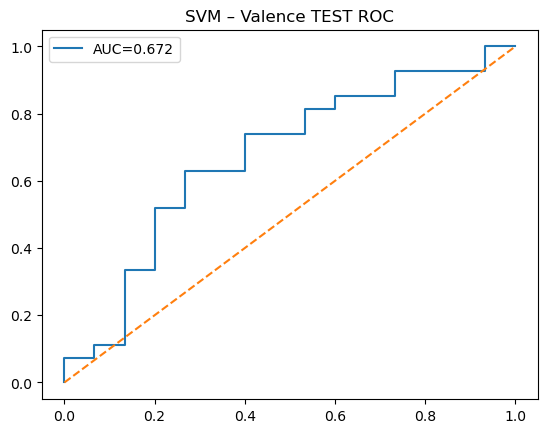

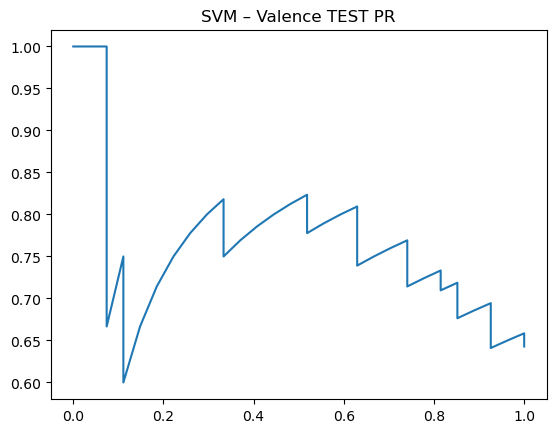

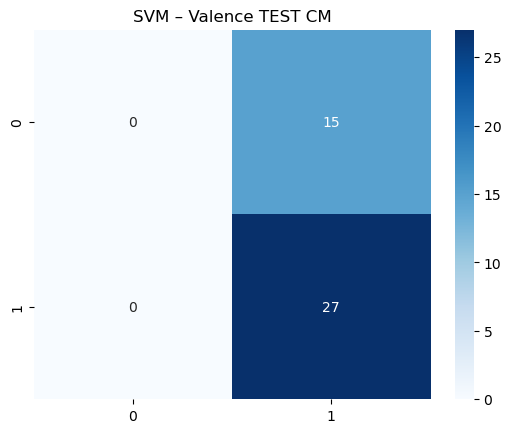


===== MLP – Valence TEST =====
Accuracy: 0.6429 | Precision: 0.6875 | Recall: 0.8148 | F1: 0.7458
AUC: 0.5864 | Kappa: 0.1600


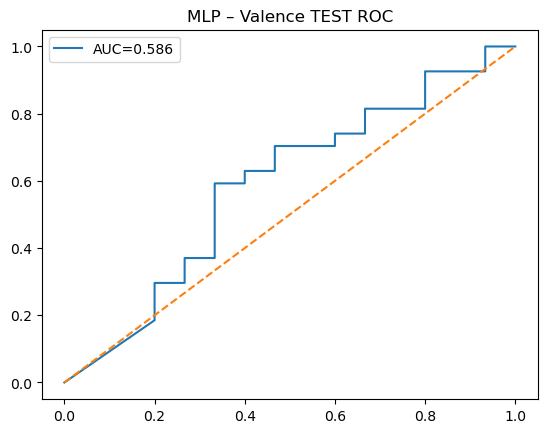

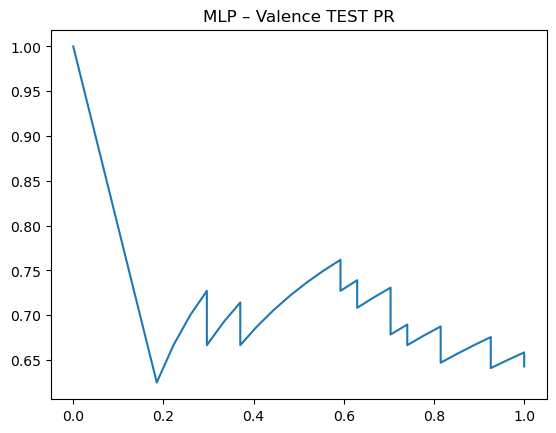

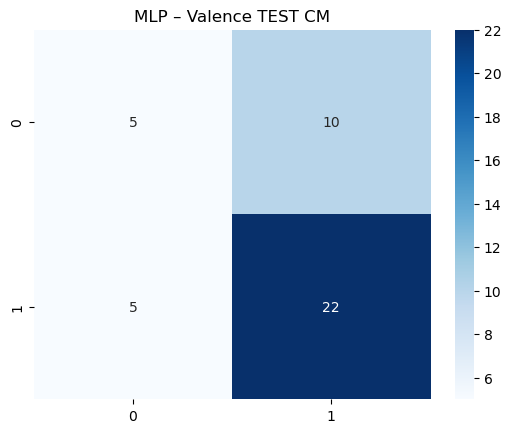


===== Cascade Forest – Valence TEST =====
Accuracy: 0.6429 | Precision: 0.6765 | Recall: 0.8519 | F1: 0.7541
AUC: 0.5988 | Kappa: 0.1322


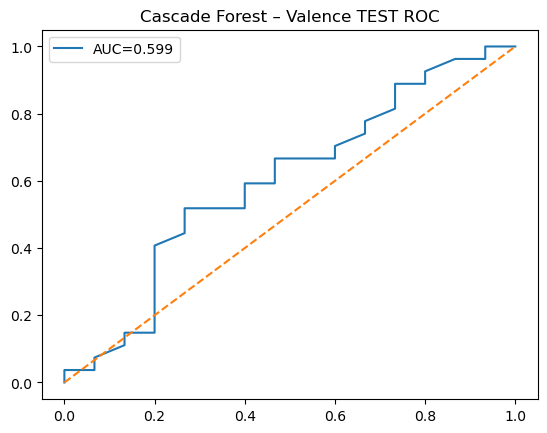

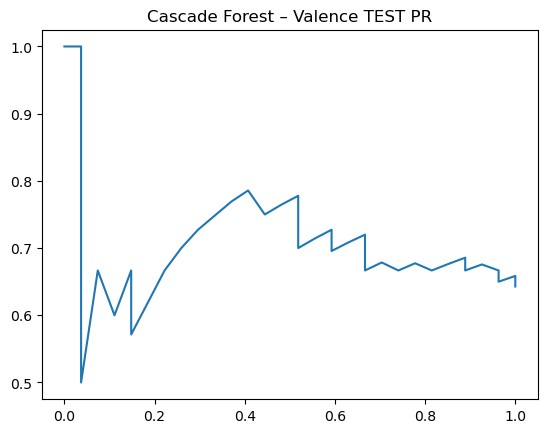

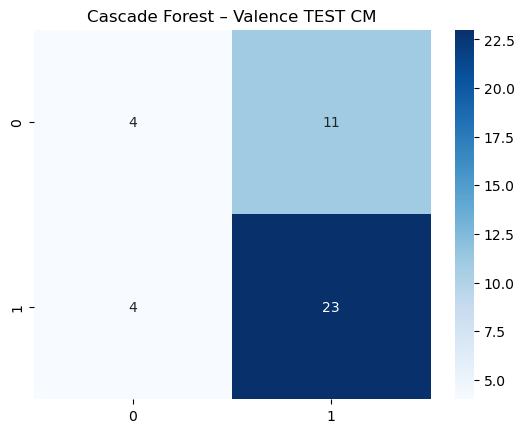


===== CNN – Valence TEST =====
Accuracy: 0.6905 | Precision: 0.6842 | Recall: 0.9630 | F1: 0.8000
AUC: 0.5975 | Kappa: 0.1947


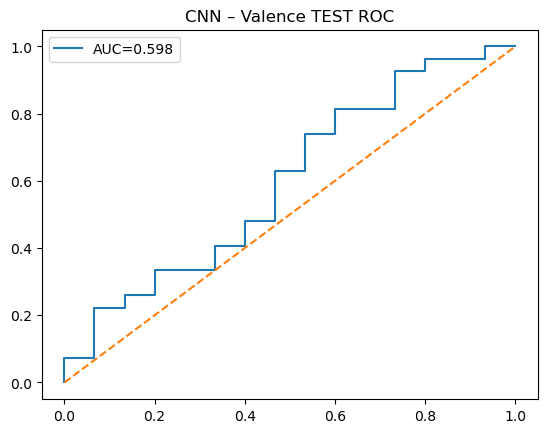

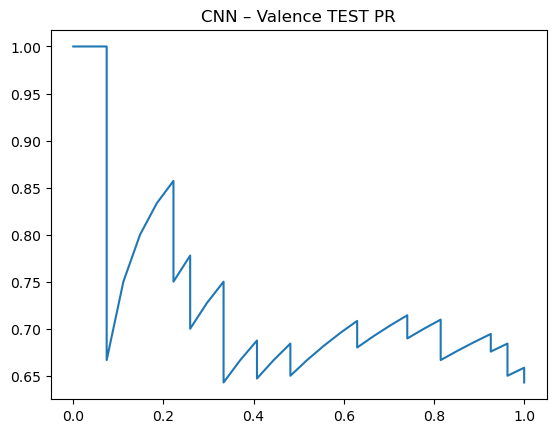

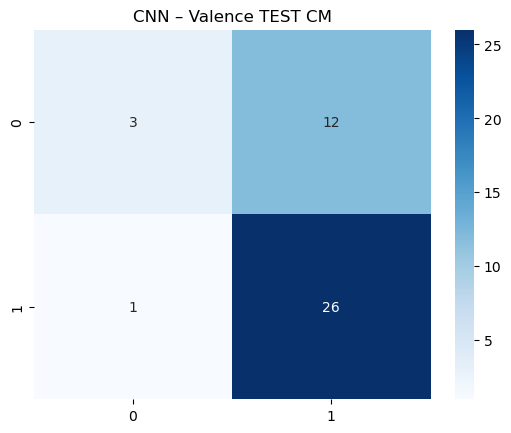


===== CNN-BiLSTM – Valence TEST =====
Accuracy: 0.6429 | Precision: 0.7143 | Recall: 0.7407 | F1: 0.7273
AUC: 0.6691 | Kappa: 0.2105


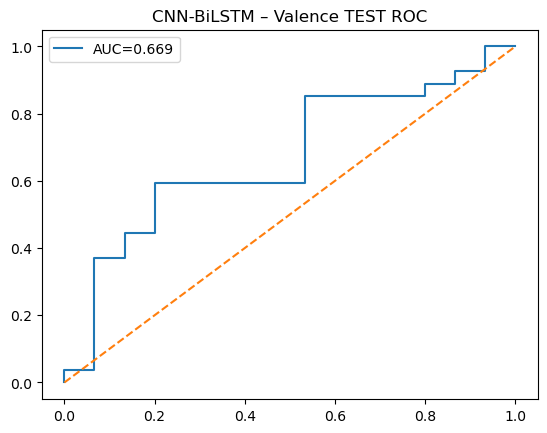

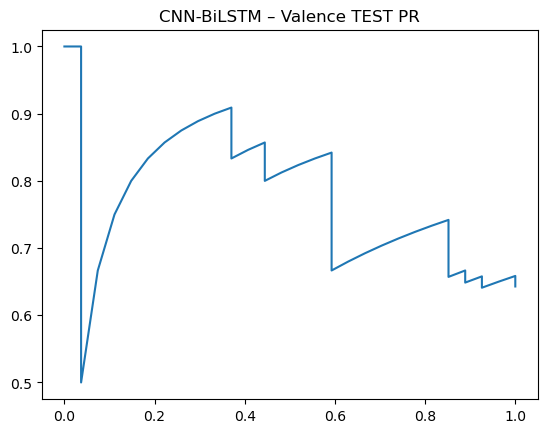

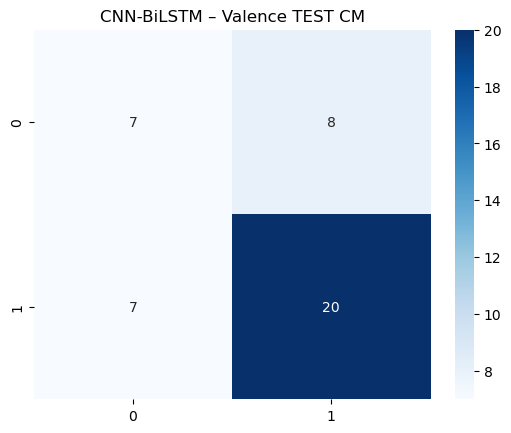


===== CNN-RNN – Valence TEST =====
Accuracy: 0.6190 | Precision: 0.6667 | Recall: 0.8148 | F1: 0.7333
AUC: 0.6148 | Kappa: 0.0894


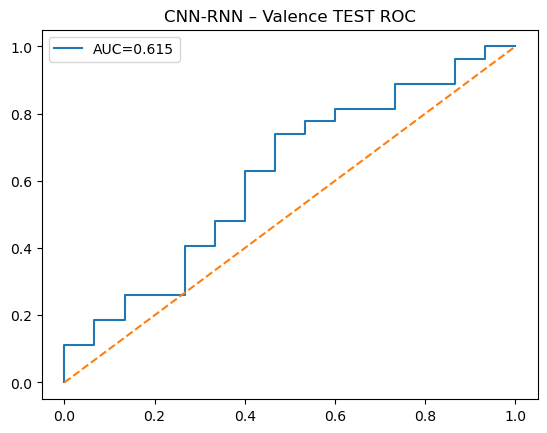

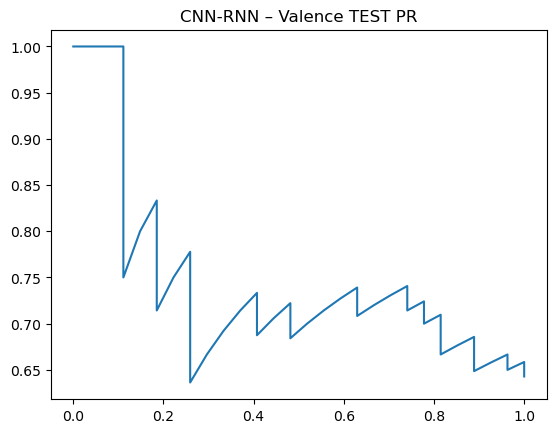

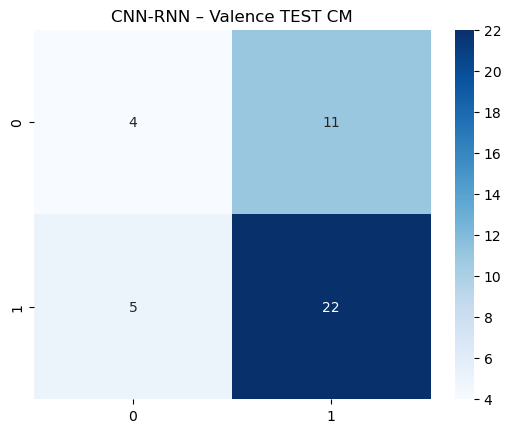


===== CapsNet – Valence TEST =====
Accuracy: 0.5952 | Precision: 0.6667 | Recall: 0.7407 | F1: 0.7018
AUC: 0.6000 | Kappa: 0.0775


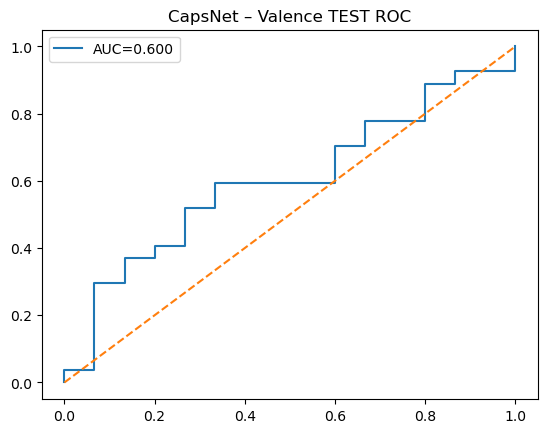

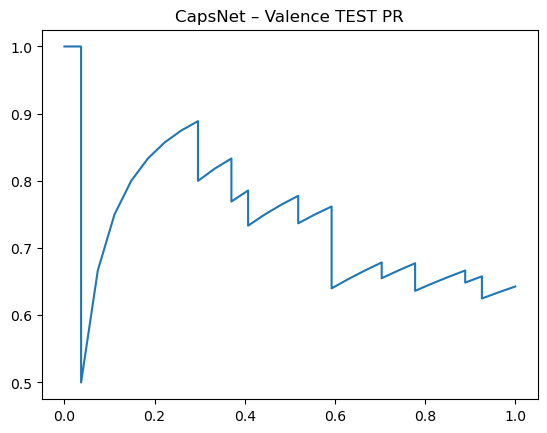

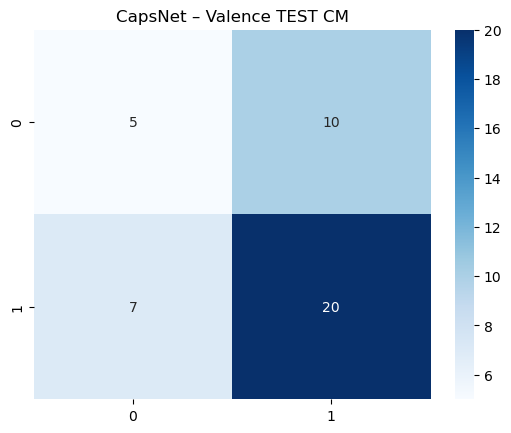


===== SVM – Arousal TEST =====
Accuracy: 0.7381 | Precision: 0.7750 | Recall: 0.9394 | F1: 0.8493
AUC: 0.6498 | Kappa: -0.0845


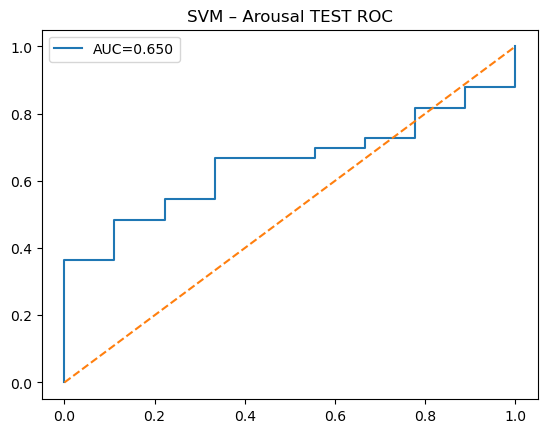

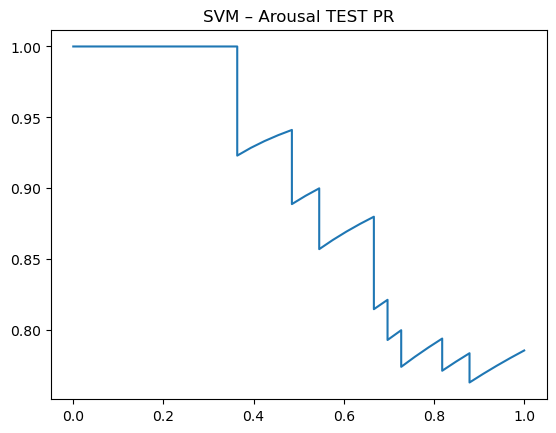

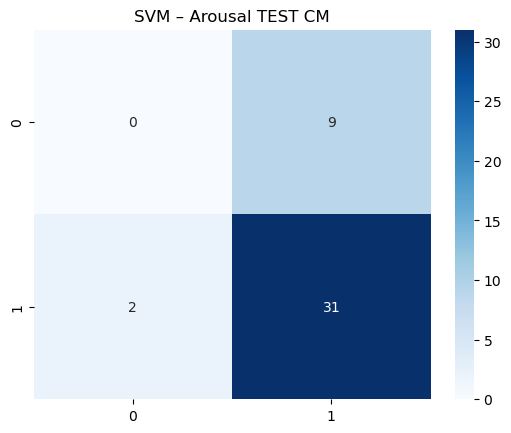


===== MLP – Arousal TEST =====
Accuracy: 0.6905 | Precision: 0.8333 | Recall: 0.7576 | F1: 0.7937
AUC: 0.6801 | Kappa: 0.1802


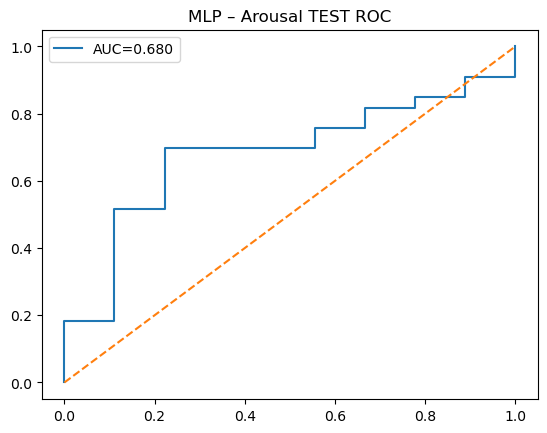

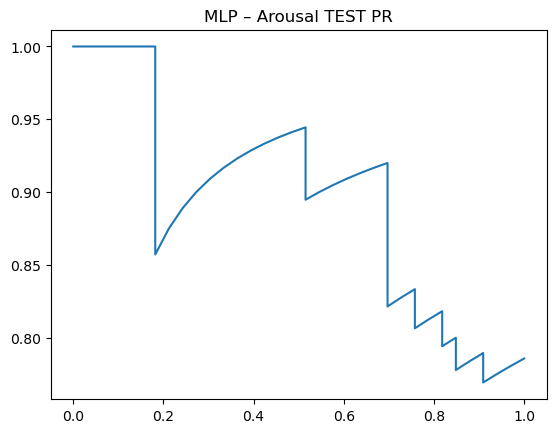

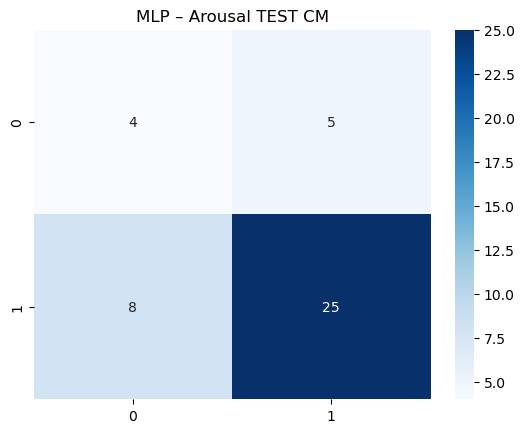


===== Cascade Forest – Arousal TEST =====
Accuracy: 0.7619 | Precision: 0.7805 | Recall: 0.9697 | F1: 0.8649
AUC: 0.6094 | Kappa: -0.0448


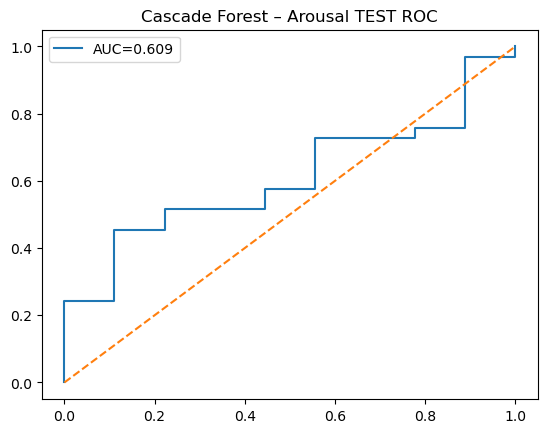

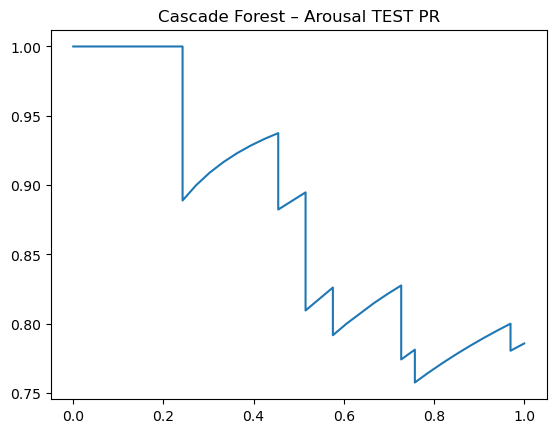

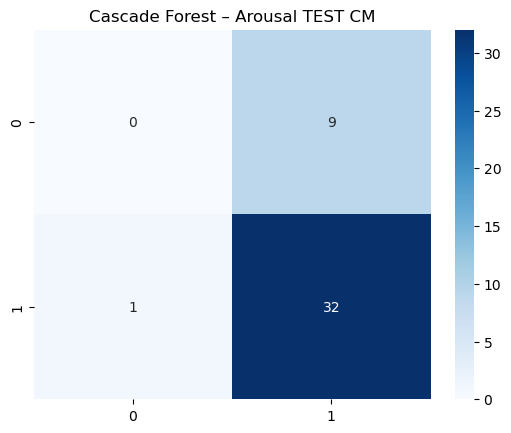


===== CNN – Arousal TEST =====
Accuracy: 0.7619 | Precision: 0.7805 | Recall: 0.9697 | F1: 0.8649
AUC: 0.4714 | Kappa: -0.0448


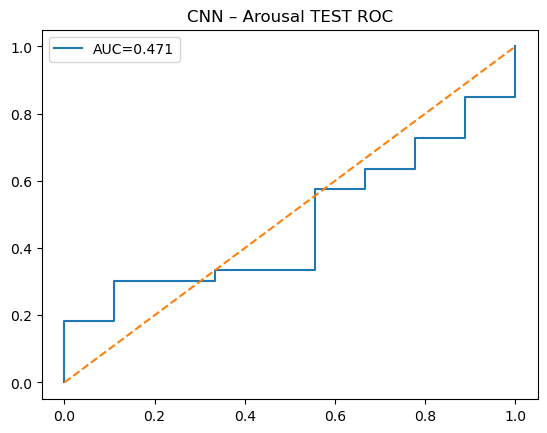

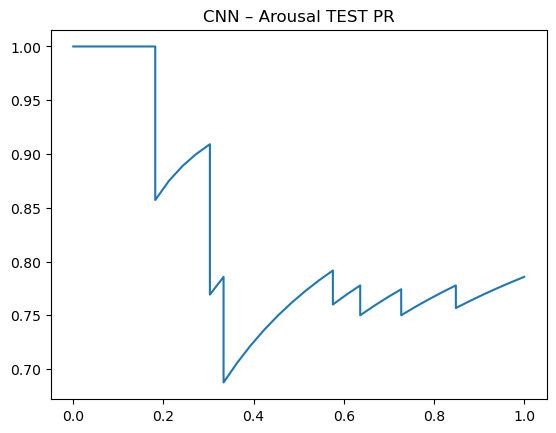

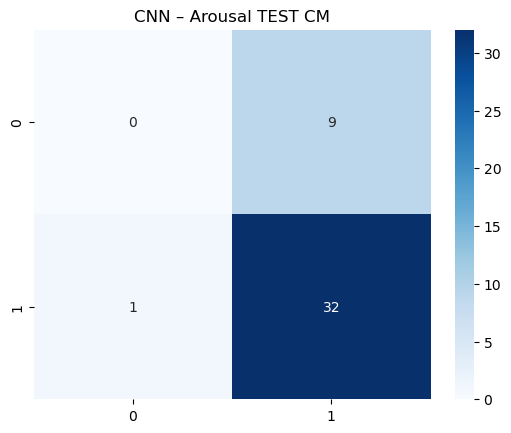


===== CNN-BiLSTM – Arousal TEST =====
Accuracy: 0.6667 | Precision: 0.7568 | Recall: 0.8485 | F1: 0.8000
AUC: 0.6431 | Kappa: -0.1807


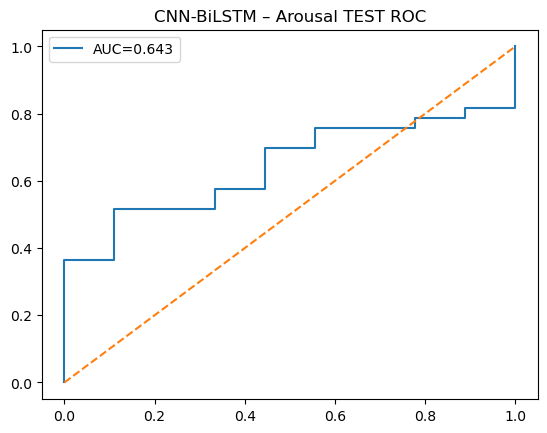

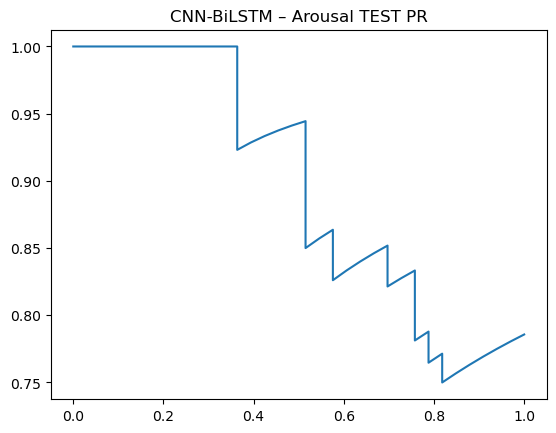

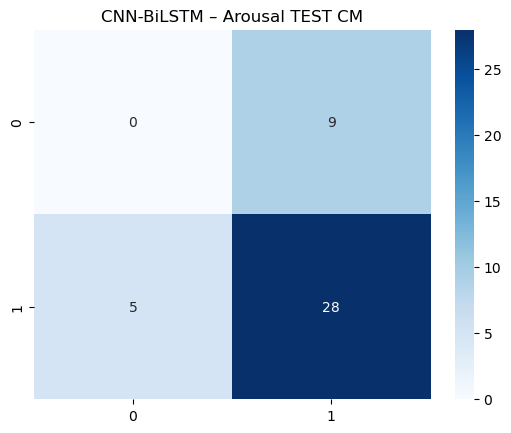


===== CNN-RNN – Arousal TEST =====
Accuracy: 0.7143 | Precision: 0.7692 | Recall: 0.9091 | F1: 0.8333
AUC: 0.4916 | Kappa: -0.1200


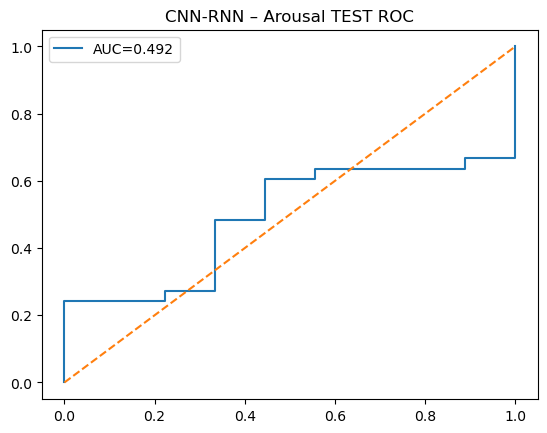

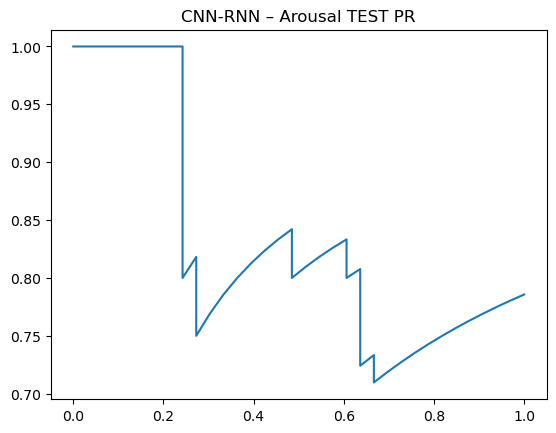

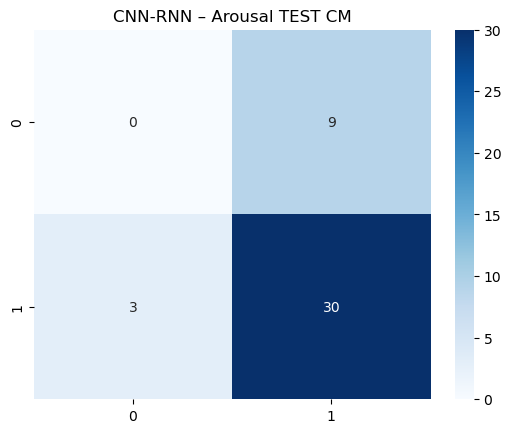


===== CapsNet – Arousal TEST =====
Accuracy: 0.6667 | Precision: 0.7714 | Recall: 0.8182 | F1: 0.7941
AUC: 0.6296 | Kappa: -0.0769


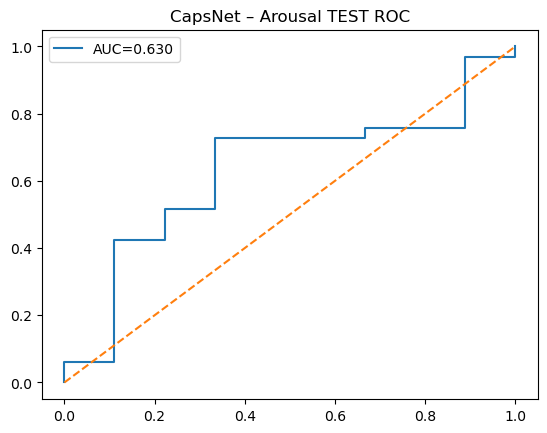

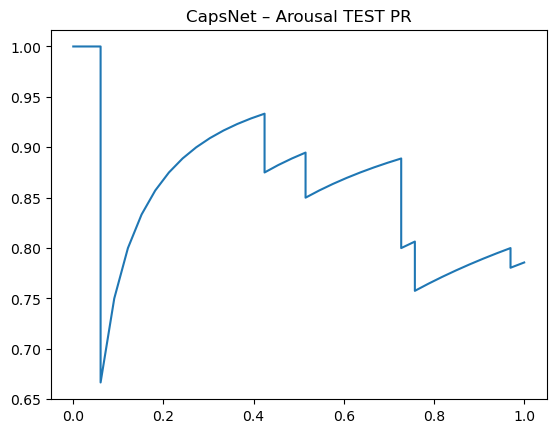

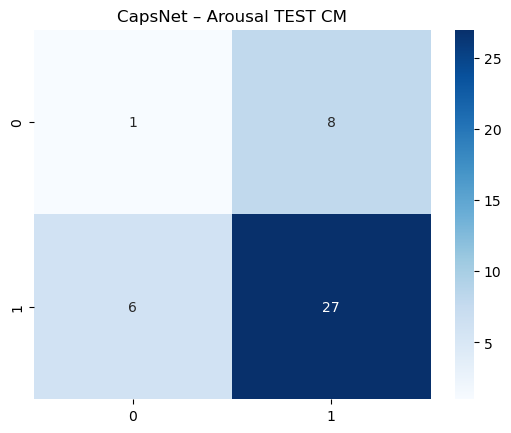


===== SUMMARY TABLE =====
            Model Valence Acc (%) Arousal Acc (%)
0             SVM          64.29%          73.81%
1             MLP          64.29%          69.05%
2  Cascade Forest          64.29%          76.19%
3             CNN          69.05%          76.19%
4      CNN-BiLSTM          64.29%          66.67%
5         CNN-RNN          61.90%          71.43%
6         CapsNet          59.52%          66.67%


In [12]:
# ============================================================
# MULTI-MODEL EEG EMOTION RECOGNITION ON DREAMER
# MODELS: SVM | CNN | CNN-BiLSTM | CNN-RNN | MLP | CapsNet | Cascade Forest
# METRICS: TRAIN / VAL / TEST + SUMMARY TABLE
# ============================================================

import random, copy
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import stft, resample

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve, cohen_kappa_score
)

import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- CONFIG ----------------
DREAMER_PATH = r"C:\Users\akash\Downloads\DREAMER.mat"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FS = 128
NPERSEG = 256
NOVERLAP = 128
FREQ_MAX = 45
FREQ_BINS = 36
TIME_BINS = 32

BATCH_SIZE = 32
EPOCHS = 40
LR = 1e-3

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ---------------- SUMMARY STORAGE ----------------
SUMMARY = {
    "Model": [],
    "Valence Acc (%)": [],
    "Arousal Acc (%)": []
}

# ============================================================
# LOAD DREAMER
# ============================================================
def load_dreamer(mat_path):
    mat = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    data = mat["DREAMER"].Data

    X, y_val, y_aro = [], [], []

    for subj in np.atleast_1d(data):
        for i, trial in enumerate(subj.EEG.stimuli):
            sig = np.asarray(trial, float)
            ch_imgs = []

            for ch in range(sig.shape[1]):
                f, _, Z = stft(sig[:, ch], FS, nperseg=NPERSEG, noverlap=NOVERLAP)
                P = np.log(np.abs(Z[f <= FREQ_MAX])**2 + 1e-12)
                P = resample(resample(P, FREQ_BINS, axis=0), TIME_BINS, axis=1)
                ch_imgs.append(P)

            X.append(np.stack(ch_imgs))
            y_val.append(subj.ScoreValence[i])
            y_aro.append(subj.ScoreArousal[i])

    return np.array(X, np.float32), np.array(y_val), np.array(y_aro)

# ============================================================
# SPLIT & BINARIZE
# ============================================================
def split_data(X, y):
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.2, random_state=SEED)
    X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=SEED)
    thr = np.median(y_tr)
    return X_tr, X_val, X_te, (y_tr>=thr), (y_val>=thr), (y_te>=thr)

# ============================================================
# METRICS & PLOTS
# ============================================================
def evaluate(y_true, y_prob, title):
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    auc = roc_auc_score(y_true, y_prob)
    kappa = cohen_kappa_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n===== {title} =====")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(f"AUC: {auc:.4f} | Kappa: {kappa:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc:.3f}"); plt.plot([0,1],[0,1],'--')
    plt.title(title + " ROC"); plt.legend(); plt.show()

    pr, rc, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(); plt.plot(rc, pr); plt.title(title + " PR"); plt.show()

    plt.figure(); sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title + " CM"); plt.show()

    return acc

# ============================================================
# DEEP MODELS
# ============================================================
class CNN(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(64,1)
    def forward(self,x): return self.fc(self.net(x).flatten(1)).squeeze(1)

class CNN_BiLSTM(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.cnn = nn.Conv2d(in_ch,64,3,padding=1)
        self.lstm = nn.LSTM(64*FREQ_BINS,64,bidirectional=True,batch_first=True)
        self.fc = nn.Linear(128,1)
    def forward(self,x):
        x = torch.relu(self.cnn(x))
        x = x.permute(0,3,1,2).reshape(x.size(0),x.size(3),-1)
        x,_ = self.lstm(x)
        return self.fc(x.mean(1)).squeeze(1)

class CNN_RNN(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.cnn = nn.Conv2d(in_ch,64,3,padding=1)
        self.rnn = nn.RNN(64*FREQ_BINS,64,batch_first=True)
        self.fc = nn.Linear(64,1)
    def forward(self,x):
        x = torch.relu(self.cnn(x))
        x = x.permute(0,3,1,2).reshape(x.size(0),x.size(3),-1)
        x,_ = self.rnn(x)
        return self.fc(x.mean(1)).squeeze(1)

class CapsNet(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch,64,3,padding=1)
        self.fc = nn.Linear(64*FREQ_BINS*TIME_BINS,1)
    def forward(self,x): return self.fc(torch.relu(self.conv(x)).flatten(1)).squeeze(1)

# ============================================================
# TRAIN DEEP MODEL
# ============================================================
def train_deep(model, Xtr, ytr):
    model.to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=LR)
    crit = nn.BCEWithLogitsLoss()
    Xtr = torch.tensor(Xtr).to(DEVICE)
    ytr = torch.tensor(ytr).float().to(DEVICE)
    for _ in range(EPOCHS):
        opt.zero_grad()
        loss = crit(model(Xtr), ytr)
        loss.backward()
        opt.step()

# ============================================================
# MAIN
# ============================================================
if __name__ == "__main__":
    X, y_val, y_aro = load_dreamer(DREAMER_PATH)

    for emotion, y in [("Valence", y_val), ("Arousal", y_aro)]:
        X_tr, X_val, X_te, y_tr, y_val_b, y_te = split_data(X, y)

        # Classical models
        Xf = StandardScaler().fit_transform(X.reshape(len(X), -1))
        Xf_tr, Xf_val, Xf_te, ytr, yv, yt = split_data(Xf, y)

        classical = {
            "SVM": SVC(probability=True),
            "MLP": MLPClassifier(max_iter=300),
            "Cascade Forest": RandomForestClassifier(n_estimators=300)
        }

        for name, model in classical.items():
            model.fit(Xf_tr, ytr)
            acc = evaluate(yt, model.predict_proba(Xf_te)[:,1], f"{name} – {emotion} TEST")
            if emotion == "Valence":
                SUMMARY["Model"].append(name)
                SUMMARY["Valence Acc (%)"].append(acc*100)
                SUMMARY["Arousal Acc (%)"].append(None)
            else:
                idx = SUMMARY["Model"].index(name)
                SUMMARY["Arousal Acc (%)"][idx] = acc*100

        # Deep models
        deep = {
            "CNN": CNN(X.shape[1]),
            "CNN-BiLSTM": CNN_BiLSTM(X.shape[1]),
            "CNN-RNN": CNN_RNN(X.shape[1]),
            "CapsNet": CapsNet(X.shape[1])
        }

        for name, model in deep.items():
            train_deep(model, X_tr, y_tr)
            with torch.no_grad():
                prob = torch.sigmoid(model(torch.tensor(X_te).to(DEVICE))).cpu().numpy()
            acc = evaluate(y_te, prob, f"{name} – {emotion} TEST")

            if emotion == "Valence":
                SUMMARY["Model"].append(name)
                SUMMARY["Valence Acc (%)"].append(acc*100)
                SUMMARY["Arousal Acc (%)"].append(None)
            else:
                idx = SUMMARY["Model"].index(name)
                SUMMARY["Arousal Acc (%)"][idx] = acc*100

    # ============================================================
    # FINAL SUMMARY TABLE
    # ============================================================
    df = pd.DataFrame(SUMMARY)
    df["Valence Acc (%)"] = df["Valence Acc (%)"].map(lambda x: f"{x:.2f}%")
    df["Arousal Acc (%)"] = df["Arousal Acc (%)"].map(lambda x: f"{x:.2f}%")

    print("\n===== SUMMARY TABLE =====")
    print(df)